In [65]:
%matplotlib inline
import os
import math

import matplotlib.pyplot as plt
import keras
from keras.models import Model, Sequential, load_model
from keras.layers import *
from keras.optimizers import Adam
import keras.backend as K

import tensorflow as tf
import numpy as np

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

print("Keras version: {}".format(keras.__version__))
print("Tensorflow version: {}".format(tf.__version__))
print("Numpy version: {}".format(np.__version__))
print("Pandas version: {}".format(pd.__version__))

Keras version: 2.0.8
Tensorflow version: 1.3.0
Numpy version: 1.13.1
Pandas version: 0.18.1


# Training a neural network to sum

In this particular exercise, we train a fully connected network to do a simple addition.

Input: 2 integers, from 0-100

Twist: train this as a classification problem

In [66]:
# Generate samples
num_samples = 50000
input_range_lo = 0 # inclusive
input_range_hi = 100
n_classes = (input_range_hi * 2) - 2 * input_range_lo + 1

def generate_samples(num_samples, lo, hi):
    X = pd.DataFrame(np.random.randint(lo, hi+1, size=2*num_samples,).reshape(num_samples, 2))
    
    X['y'] = X[0] + X[1]
    
    #Ensure uniqueness
    #X.drop_duplicates(inplace=True) ##Makes problem much harder
    
    #TODO: Drop some numbers
    return X[[0, 1]].values, X['y'].values

X, y = generate_samples(num_samples, input_range_lo, input_range_hi)
print(X[:5], y[:5])


[[48  6]
 [98 91]
 [ 6 84]
 [25 74]
 [30 25]] [ 54 189  90  99  55]


To be truely data-agnostic, we should code the normalisation and min-max finding process to fit the generates samples.

But I'm lazy, so lets use our prior knowledge

In [67]:
#Normalize data to 0->1, and perform OHE
def transform_X(X):
    X_float = X.astype(np.float32) - input_range_lo
    X_float /= (input_range_hi - input_range_lo)
    return X_float

def invert_X(X_float):
    X = X_float * (input_range_hi - input_range_lo)
    X += input_range_lo
    X = X.astype(int)
    return X

one_hot_labels = keras.utils.to_categorical(y, num_classes=n_classes)

X_train, X_test, y_train, y_test = train_test_split(X, one_hot_labels, test_size=0.2)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_train[:5])

(40000, 2) (40000, 201)
(10000, 2) (10000, 201)
[[33 27]
 [54 45]
 [ 9 36]
 [36 31]
 [22 24]]


We pick a few random numbers to remove, and add these subsequently to the test set later

**Note: Running this cell multiple times will reduce the number of samples again!***

In [68]:
num_to_hide = np.random.choice(range(input_range_lo, input_range_hi+1), size=3, replace=False)
print("Removing", num_to_hide)

def remove_numbers(X, y, num_to_hide):
    old_len = len(X)
    for num in num_to_hide:
        y = y[(X[:,0]!=num) & (X[:,1]!=num)]
        X = X[(X[:,0]!=num) & (X[:,1]!=num) ,:]
    print("Removed", old_len - len(X), "samples. Now training with ", len(X), "samples")
    assert(len(X) == len(y))
    return X, y

X_train, y_train = remove_numbers(X_train, y_train, num_to_hide)

Removing [23 71 99]
Removed 2317 samples. Now training with  37683


In [69]:
#Normalize data
X_train = transform_X(X_train)
X_test = transform_X(X_test)

In [70]:
#Generate model here

def gen_model(n_classes, n_hidden_list=[64,128], activation='elu'):
    inputs = Input(shape=(2,))
    x = Dense(n_hidden_list[0], activation=activation, name = "Dense_0")(inputs)
    if len(n_hidden_list) > 1:
        for idx, n_hidden in enumerate(n_hidden_list[1:]):
            x = Dense(n_hidden, activation=activation, name = "Dense_"+str(idx+1))(x)
    outputs = Dense(n_classes, activation='softmax', name = "Outputlayer")(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adamax',
                 metrics=['acc'])
    return model

model = gen_model(n_classes)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
Dense_0 (Dense)              (None, 64)                192       
_________________________________________________________________
Dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
Outputlayer (Dense)          (None, 201)               25929     
Total params: 34,441
Trainable params: 34,441
Non-trainable params: 0
_________________________________________________________________


In [71]:
# Training Parameters
#learning_rate = 0.001
#decay = 0.005
training_epochs = 200
#batch_size = 128

#K.set_value(model.optimizer.lr, learning_rate)
#K.set_value(model.optimizer.momentum, 0.3)
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 1.0
    drop = 0.6
    epochs_drop = 15.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    print(lrate)
    return lrate
#lrate = LearningRateScheduler(step_decay)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2,
              patience=10, min_lr=0.0003)
model_chkpt = ModelCheckpoint(filepath='addition_zy.hdf5', monitor='val_acc', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, 
                    epochs=training_epochs, 
                    shuffle=True, 
                    validation_split=0.15,
                   callbacks=[reduce_lr, model_chkpt])
# callbacks=[lrate]

Train on 32030 samples, validate on 5653 samples
Epoch 1/200
32030/32030 [==============================] - 1s - loss: 4.5632 - acc: 0.0313 - val_loss: 3.8743 - val_acc: 0.0775
Epoch 2/200
32030/32030 [==============================] - 2s - loss: 3.5233 - acc: 0.0868 - val_loss: 3.2148 - val_acc: 0.1123
Epoch 3/200
32030/32030 [==============================] - 1s - loss: 3.0340 - acc: 0.1342 - val_loss: 2.8669 - val_acc: 0.1456
Epoch 4/200
32030/32030 [==============================] - 1s - loss: 2.7430 - acc: 0.1665 - val_loss: 2.6218 - val_acc: 0.1817
Epoch 5/200
32030/32030 [==============================] - 1s - loss: 2.5391 - acc: 0.2022 - val_loss: 2.4686 - val_acc: 0.2211
Epoch 6/200
32030/32030 [==============================] - 1s - loss: 2.3889 - acc: 0.2268 - val_loss: 2.3357 - val_acc: 0.2459
Epoch 7/200
32030/32030 [==============================] - 1s - loss: 2.2692 - acc: 0.2505 - val_loss: 2.1920 - val_acc: 0.2537
Epoch 8/200
32030/32030 [==============================

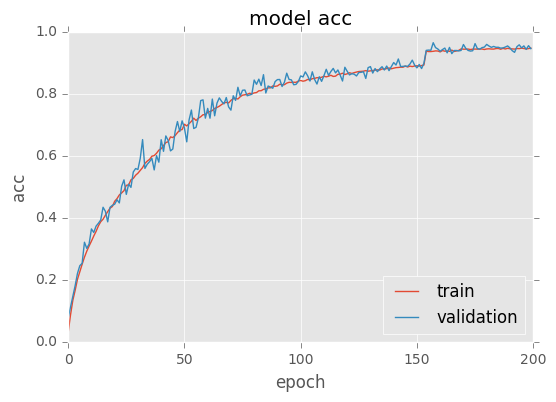

In [72]:
def plot_train(hist):
    h = hist.history
    if 'acc' in h:
        meas='acc'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.style.use('ggplot')
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)
    
plot_train(history)

In [73]:
model = load_model("addition_zy.hdf5")

In [74]:
# Now try testing on unseen data
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.392450018311
Test accuracy: 0.9534


In [75]:
pred = model.predict(X_test)
print(np.argmax(pred[:5], axis=1))
print(np.argmax(y_test[:5], axis=1))

[105 104 111 106  99]
[105 104 111 106  99]


Not too bad, but can we confirm that it has generalised to examples it hasn't seen?

Try testing on the removed numbers only

In [76]:
def gen_special_numbers(samples, num_to_hide):
    X = pd.DataFrame(np.random.randint(input_range_lo, input_range_hi+1, size=2*samples,).reshape(samples, 2))
    X['y'] = X[0] + X[1]
    X = X[(X[0].isin(num_to_hide)) | (X[0].isin(num_to_hide))]
    print(len(X), "samples generated")
    y = X['y'].values
    X = X[[0,1]].values
    return X, y

X_test_new, y_test_new = gen_special_numbers(10000, num_to_hide)
X_test_new_float = transform_X(X_test_new)
y_test_new = keras.utils.to_categorical(y_test_new, num_classes=n_classes)
score = model.evaluate(X_test_new_float, y_test_new, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

pred = model.predict(X_test_new_float)
sample_final_results = pd.DataFrame({'x0':X_test_new[:,0],
                                    'x1':X_test_new[:,1],
                                    'y':np.argmax(y_test_new, axis=1),
                                    'y_pred': np.argmax(pred, axis=1)}).sample(n=10).reset_index(drop=True)
print("Hidden numbers:", num_to_hide)
sample_final_results

277 samples generated
Test loss: 0.290400463429
Test accuracy: 0.967509030005
Hidden numbers: [23 71 99]


,x0,x1,y,y_pred
0,23,20,43,43
1,99,40,139,139
2,71,3,74,74
3,99,44,143,143
4,99,45,144,144
5,71,31,102,102
6,71,79,150,150
7,71,48,119,119
8,23,2,25,25
9,71,73,144,144


TODO: FIND MINIMAL MODEL SIZE / SAMPLE SIZE

# Concluding remarks
Our network has managed to generalise to unseen inputs. There are still sources of error, most likely coming from examples with fewer classes (e.g. the ones near 0 and 200). Another possibility of data generation is to iterate through output samples and fix the number for each class.